# MD008 Redes Neuronales Entrega 1: MPL

Para la realización de este proyecto he escogido el problema de League Of Legends y lo primero será como no, la importacion de las librerias.

In [156]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

Una vez importadas las librerias creo un pequeño script para leer todos los ficheros y meterlos en un dataframe, añadiendo al parche al que pertenecen.

In [157]:
data = pd.DataFrame()

for i in range (1,24):
    dtf = pd.read_csv(f'.\league_stats\League of Legends Champion Stats 12.{i}.csv', sep = ';', encoding = 'latin1', error_bad_lines=False)
    dtf['patch'] = i
    data = data.append(dtf, ignore_index=True)

data.sample(5)

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,patch
1125,Teemo,Marksman,TOP,S,69.89,-1.34,51.38%,78.10%,5.57%,9.89%,1.71,5
4007,Teemo,Marksman,TOP,S,57.49,-4.21,51.53%,77.84%,4.82%,7.97%,1.76,17
2881,Aurelion Sol,Mage,MID,C,40.52,-0.43,49.24%,88.00%,0.83%,0.30%,2.48,13
4721,Sona,Support,SUPPORT,A,52.31,-3.04,51.73%,97.06%,3.84%,0.38%,2.86,20
5196,Samira,Marksman,ADC,S,66.13,4.14,51.28%,96.93%,9.56%,21.82%,2.20,22


In [158]:
data.describe()

,Score,Trend,KDA,patch
count,5544.000000,5544.000000,5544.000000,5544.000000
mean,50.000049,-0.033120,2.329205,12.102273
std,14.498281,6.203694,0.410395,6.645572
min,3.490000,-38.440000,1.030000,1.000000
25%,40.737500,-2.740000,2.050000,6.000000
50%,47.425000,-0.155000,2.310000,12.000000
75%,56.435000,2.400000,2.560000,18.000000
max,97.420000,64.580000,4.400000,23.000000


Como observamos tenemos 5544 muestras y ciertas columnas como los porcentajes que tendremos que tratar ya que no las queremos como Strings. Tenemos un dataframe amplio, sin embargo es de todas las posiciones y a nosotros solo nos interesan los datos de los supports. Si bien es cierto que podriamos usar las demas posiciones para tratar de encontrar los limites, también hay que tener en cuenta que estas podrian añadir ruido al modelo ya que la posicion de support es bastante especialita. Es decir, variables como el ban rate serán mucho menores en support que en otras posiciones como Mid, por lo que eventualmente sera mejor solo quedarme con los supports. Pero antes voy a mirar como vamos de nulos.

In [159]:
print("Proporción de valores nulos (%)")
data.isnull().sum() / len(data) * 100

Proporción de valores nulos (%)


Name      0.000000
Class     0.018038
Role      0.000000
Tier      0.000000
Score     0.000000
Trend     0.000000
Win %     0.000000
Role %    0.000000
Pick %    0.000000
Ban %     0.000000
KDA       0.000000
patch     0.000000
dtype: float64

Bastante limpio, la única columna con valores nulos es la clase, asi que en vez de tenerlos nulos, canviaremos estos por 'Unknown'.

In [160]:
data['Class'].fillna("Unknown", inplace = True) 

Lo siguiente será deshacerme de los porcentajes y meterlos como Floats para poder jugar con ellos.

In [161]:
data['Win %'] = data['Win %'].str.rstrip('%').astype('float') 
data['Ban %'] = data['Ban %'].str.rstrip('%').astype('float') 
data['Role %'] = data['Role %'].str.rstrip('%').astype('float') 
data['Pick %'] = data['Pick %'].str.rstrip('%').astype('float') 

data = data.rename(columns={'Win %': 'WinPerc', 'Role %': 'RolePerc', 'Pick %': 'PickPerc', 'Ban %': 'BanPerc'})


Finalmente, como he mencionado anteriormente me quedare solo con los supports.

In [162]:
supports = data[data['Role'] == 'SUPPORT']
supports = supports.drop('Role', axis=1)
supports.sample(5)

,Name,Class,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA,patch
3085,Xerath,Mage,B,44.51,-5.52,49.75,52.33,2.79,2.76,2.65,13
484,Brand,Mage,B,45.88,4.43,51.05,69.87,3.90,5.35,1.84,3
4933,Rell,Tank,B,46.30,-1.26,52.19,98.19,1.97,0.39,2.51,21
3528,Taric,Support,A,55.34,1.04,54.48,86.29,3.15,0.98,2.88,15
3323,Xerath,Mage,B,47.81,3.30,51.61,56.60,2.97,2.59,2.65,14


In [163]:
from scipy.stats import chi2_contingency

tabla_contingencia = pd.crosstab(supports['Class'], supports['Tier'])

# Realizar el test de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < 0.05:
    print("Existe una asociación significativa entre las variables.")
else:
    print("No existe una asociación significativa entre las variables.")

Chi-cuadrado: 274.9011616332468
p-valor: 6.252736473724568e-44
Existe una asociación significativa entre las variables.


Aqui según el test de chi-cuadrado hemos encontrado algo que no me esperaba para nada, y es que según este test la variable clase influye en el Tier del campeón. Aunque cuando los piensas friamente, es cierto que hay seasons o parches en las que si tocan determinados items, provocan que una de las clases de campeones se chete de mala manera.

In [164]:
sup_dat = supports.drop(['patch'], axis=1)
sup_dat.head()

,Name,Class,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
6,Alistar,Tank,B,46.08,-2.74,49.92,98.55,3.65,0.84,2.51
8,Amumu,Tank,C,35.88,2.55,50.09,14.95,0.44,1.64,2.05
10,Anivia,Mage,D,31.74,-1.46,47.66,12.51,0.44,3.03,2.18
16,Bard,Support,A,49.81,2.27,50.23,98.67,4.05,1.00,2.97
17,Blitzcrank,Tank,S,67.80,-0.81,51.87,99.49,8.61,18.23,2.44


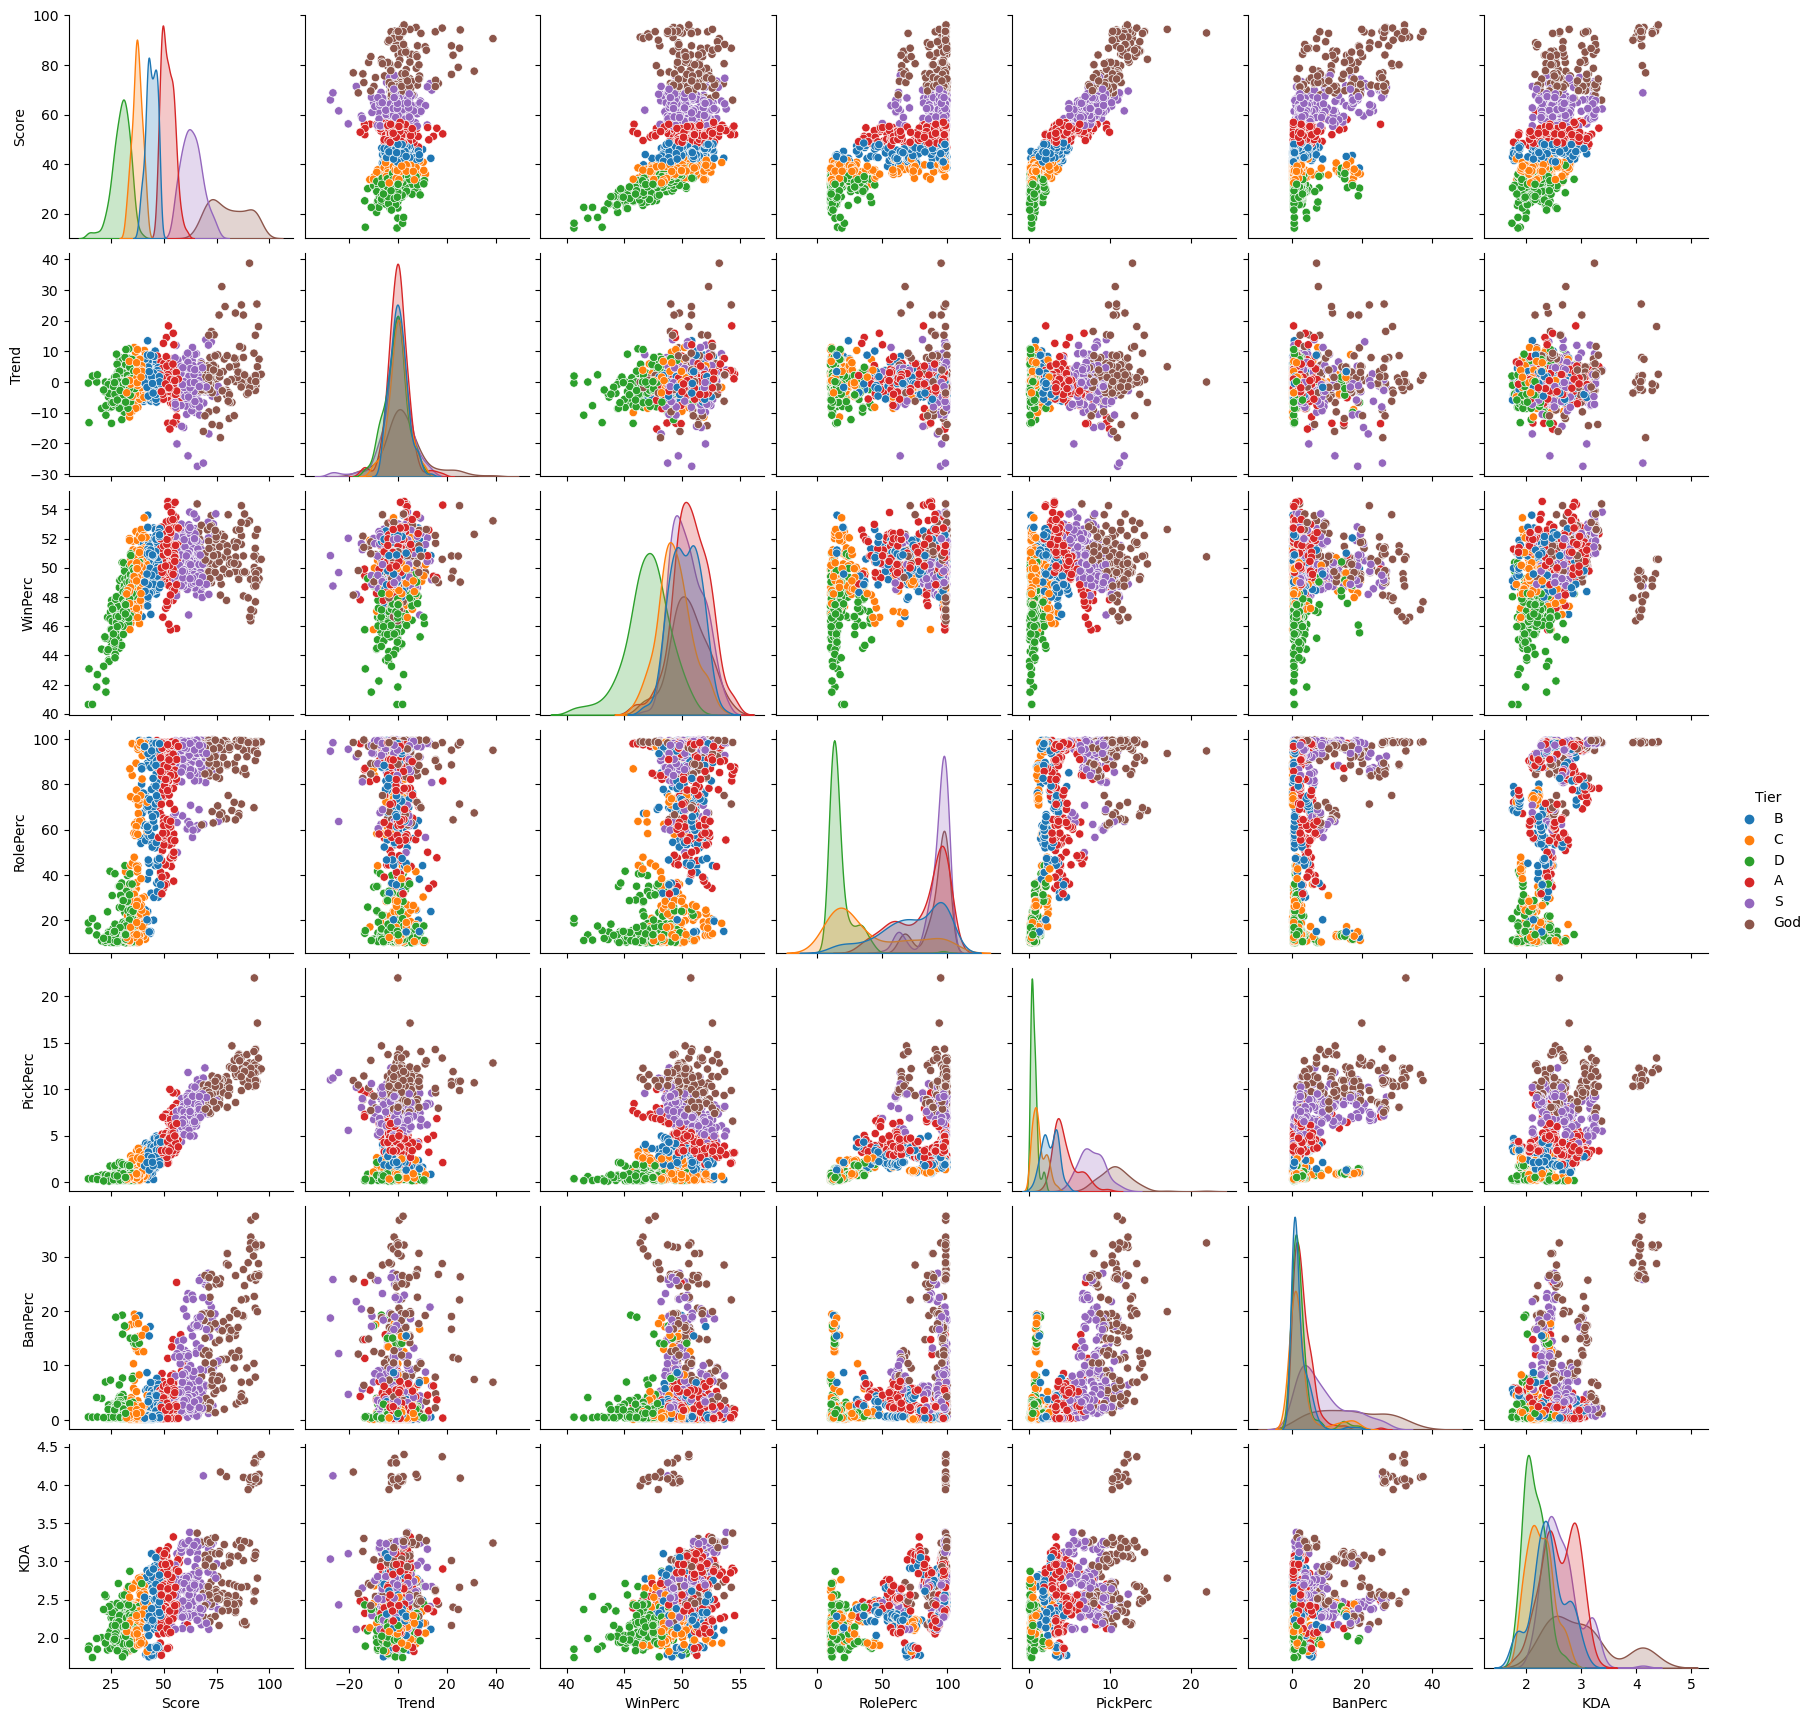

In [165]:
sns.pairplot(sup_dat, hue='Tier')
plt.show()

En estos graficos podemos apreciar como hay una clara separación de la clase Tier según la variable score, al final seguramente esta variable misma sea la que se usa para clasificar por Tiers por lo que para la red neuronal final no la usaré para meterle un poco de salsa.

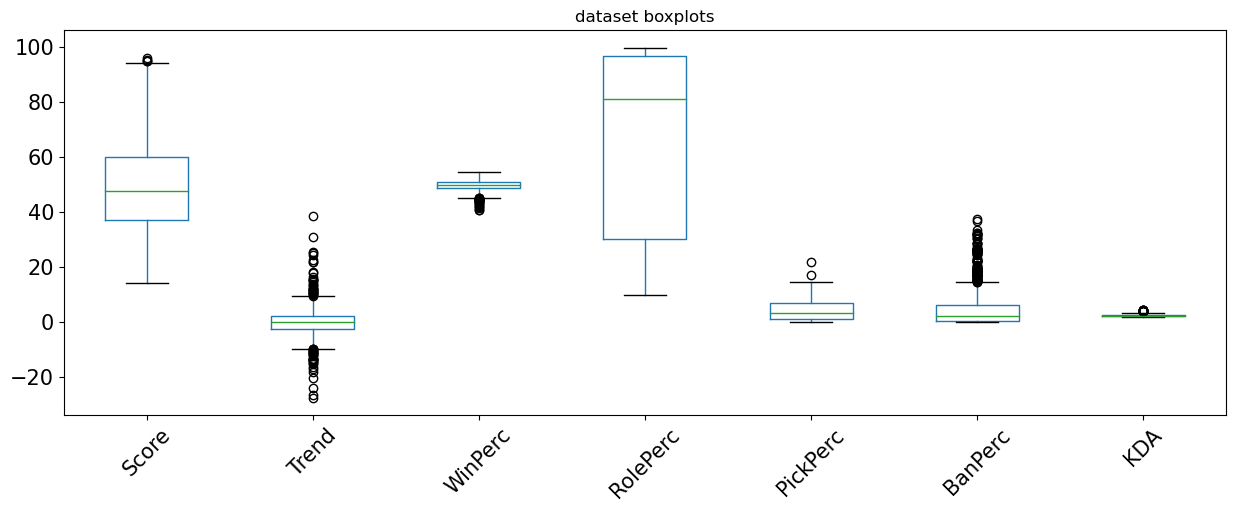

In [166]:
plt.figure(figsize = (15, 5))
plt.title("dataset boxplots")
sup_dat.boxplot(grid=False, rot=45, fontsize=15)
plt.show()

Muchissimos outliers con la variable Trend, habrá que ver que hacer con ella.

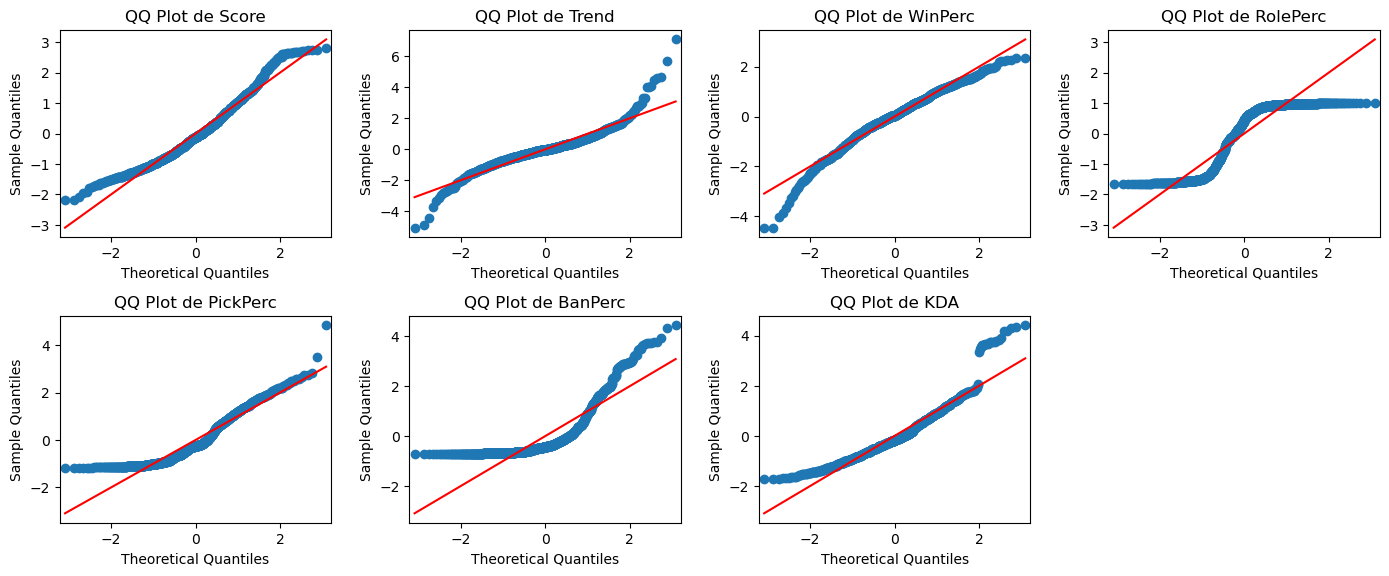

In [167]:
plt.figure(figsize=(14, 14))

data_cont = sup_dat.drop(['Tier', 'Class', 'Name'], axis=1)

for i, columna in enumerate(data_cont, 1):
    plt.subplot(5, 4, i)
    sm.qqplot(data_cont[columna], line='s', fit=True, ax=plt.gca())
    plt.title(f'QQ Plot de {columna}')

plt.tight_layout()
plt.show()

Como podemos ver la normalidad en estos datos brilla por su ausencia.

In [168]:
sup_dat.head(1)

,Name,Class,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
6,Alistar,Tank,B,46.08,-2.74,49.92,98.55,3.65,0.84,2.51


A continuación voy a realizar un mapeo de la variable Tier para que en vez de letras, los tiers sean representados por números del 1 al 6.

In [169]:
sup_dat_mapped = sup_dat

mapeo = {'D': 1, 'C': 2, 'B': 3, 'A': 4, 'S': 5, 'God': 6}
sup_dat_mapped['Tier'] = sup_dat_mapped['Tier'].replace(mapeo)

sup_dat_mapped.head(1)

,Name,Class,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
6,Alistar,Tank,3,46.08,-2.74,49.92,98.55,3.65,0.84,2.51


In [170]:
sup_dat.head(1)

,Name,Class,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
6,Alistar,Tank,3,46.08,-2.74,49.92,98.55,3.65,0.84,2.51


A continuación realizaré un test Anova para cada variable continua con la variable objetivo.

In [171]:
from statsmodels.formula.api import ols

variables = sup_dat_mapped.columns.drop(['Class', 'Tier', 'Name'])  
resultados_anova = pd.DataFrame(columns=['Variable', 'F_Value', 'P_Value'])

for variable in variables:
    formula = f'Tier ~ {variable}'  # Usa C() para tratar explícitamente la variable como categórica
    anova_result = ols(formula, data=sup_dat_mapped).fit()
    anova_table = sm.stats.anova_lm(anova_result, typ=2)  # Type 2 ANOVA DataFrame

    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]

    # Añade los resultados usando .loc para mejorar la eficiencia
    resultados_anova.loc[len(resultados_anova.index)] = [variable, f_value, p_value]

# Imprime los resultados del ANOVA
print(resultados_anova)

   Variable      F_Value        P_Value
0     Score  7956.691542   0.000000e+00
1     Trend    12.701276   3.825960e-04
2   WinPerc   400.746893   2.807641e-75
3  RolePerc  1515.341654  8.615567e-203
4  PickPerc  4283.047503   0.000000e+00
5   BanPerc   398.119799   7.202137e-75
6       KDA   542.193213   3.073542e-96


Según el test la variable objetivo marca una clara separación en las distribuciones de todas las variables, cosa que nos gusta.

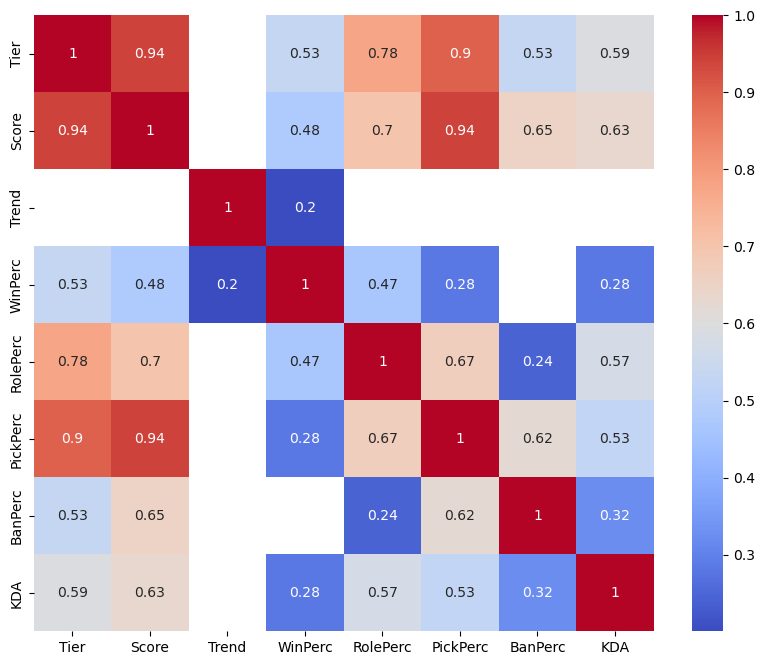

In [172]:
correlation_matrix = sup_dat.corr()
correlation_matrix[np.abs(correlation_matrix) < 0.2] = np.nan

plt.figure(figsize=(10, 8))  # You can adjust the dimensions as needed

# Use Seaborn to create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Display the heatmap
plt.show()

En esta matriz de correlaciones, observamos como tal y como esperabamos la variable score esta altamente relacionada con la variable objetivo, pero no solo ella, la variable pick % y Role % tambien lo estan. En el caso del pick rate es algo esperable ya que cuanto mas roto esta mas se va a jugar, pero en el caso del role % no me esperaba este resultado.

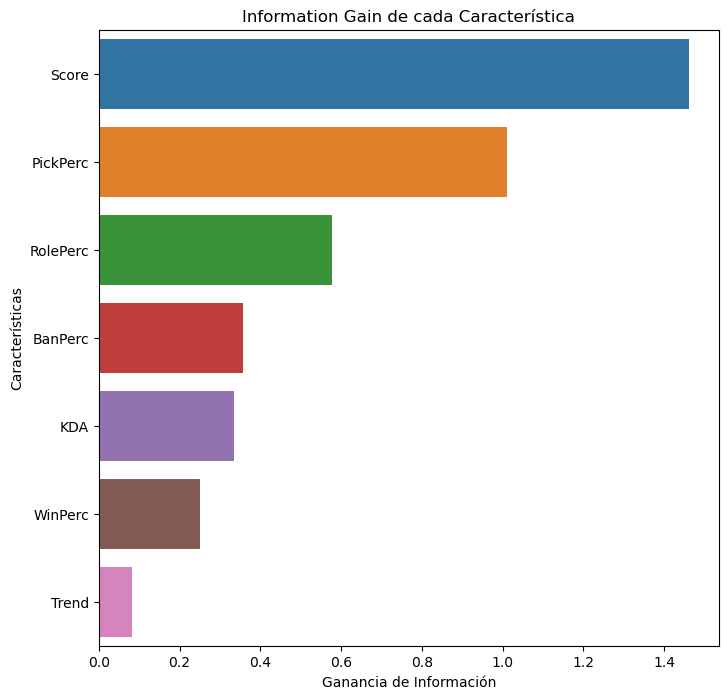

In [173]:
from sklearn.feature_selection import mutual_info_regression

def calculate_information_gain(X, y):
    mi = mutual_info_regression(X, y)
    mi = pd.Series(mi, index=X.columns)
    mi = mi.sort_values(ascending=False)
    return mi

X = sup_dat.drop(['Tier', 'Class', 'Name'], axis=1)
y = sup_dat['Tier']
mi_scores = calculate_information_gain(X, y)

# Visualizar
plt.figure(figsize=(8, 8))
sns.barplot(x=mi_scores, y=mi_scores.index)
plt.title('Information Gain de cada Característica')
plt.xlabel('Ganancia de Información')
plt.ylabel('Características')
plt.show()

En el analisis de informacion mutua observamos lo que ya habiamos visto en la matriz de correlaciones.

A continuación voy a aplicar one hot encoding en la variable Class para poder usarla correctamente y despues empezare con la red neuronal.

In [174]:
sup_dat = pd.get_dummies(sup_dat, columns=['Class'])

sup_dat.sample(5)

,Name,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA,Class_Assassin,Class_Fighter,Class_Mage,Class_Marksman,Class_Support,Class_Tank
581,Nautilus,5,62.29,0.57,50.03,96.76,8.30,8.35,2.27,0,0,0,0,0,1
2862,Zilean,3,44.15,-5.03,48.37,77.82,3.31,2.38,3.10,0,0,0,0,1,0
4722,Soraka,5,61.74,-4.90,50.95,95.86,7.53,3.73,2.80,0,0,0,0,1,0
4109,Galio,1,25.90,-6.63,47.12,16.19,0.46,0.41,2.26,0,0,0,0,0,1
5299,Amumu,4,51.53,1.56,51.94,64.41,3.58,3.07,2.12,0,0,0,0,0,1


Esta primera red neuronal contará con todas estas variables, incluida la variable score que como sabemos define muy bien los limites entre Tiers, y el objetivo de esta red sera el de clasificar correctamente los champs según su Tier.

Primero definimos los datasets de train y test.

In [313]:
X = sup_dat.drop(['Tier', 'Name'], axis = 1)
y = sup_dat['Tier']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.to_numpy(), dtype=torch.long) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Definimos el modelo.

In [314]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Inicializamos y definimos los parametros necesarios.

In [319]:
input_size = X.shape[1]
hidden_size = 18
output_size = 7  # Clases objetivo
model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

num_epochs = 1100
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

Entrenamos y evaluamos.

In [320]:
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_acc = (train_predicted == y_train).sum().item() / y_train.size(0)
        train_accuracy.append(train_acc)
        train_losses.append(train_loss.item())

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_acc = (test_predicted == y_test).sum().item() / y_test.size(0)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch [10/1100], Train Loss: 1.8287, Test Loss: 1.8626, Train Accuracy: 0.3097, Test Accuracy: 0.2871
Epoch [20/1100], Train Loss: 1.6538, Test Loss: 1.6916, Train Accuracy: 0.4005, Test Accuracy: 0.4059
Epoch [30/1100], Train Loss: 1.4772, Test Loss: 1.5157, Train Accuracy: 0.4925, Test Accuracy: 0.4703
Epoch [40/1100], Train Loss: 1.2962, Test Loss: 1.3315, Train Accuracy: 0.6169, Test Accuracy: 0.5644
Epoch [50/1100], Train Loss: 1.1200, Test Loss: 1.1513, Train Accuracy: 0.6704, Test Accuracy: 0.6287
Epoch [60/1100], Train Loss: 0.9608, Test Loss: 0.9916, Train Accuracy: 0.7127, Test Accuracy: 0.6832
Epoch [70/1100], Train Loss: 0.8257, Test Loss: 0.8573, Train Accuracy: 0.7425, Test Accuracy: 0.7129
Epoch [80/1100], Train Loss: 0.7175, Test Loss: 0.7456, Train Accuracy: 0.7823, Test Accuracy: 0.7426
Epoch [90/1100], Train Loss: 0.6332, Test Loss: 0.6554, Train Accuracy: 0.8047, Test Accuracy: 0.7871
Epoch [100/1100], Train Loss: 0.5677, Test Loss: 0.5855, Train Accuracy: 0.8271, T

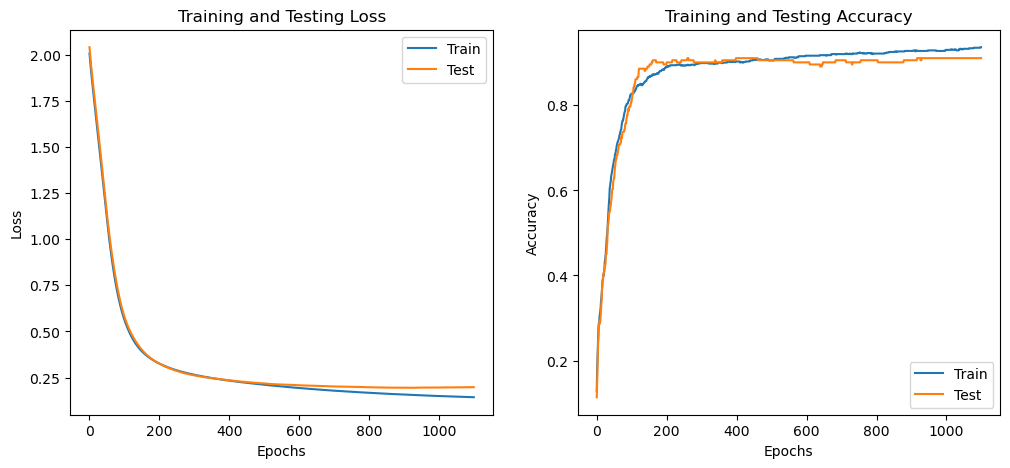

In [321]:
# Visualizamos resultados
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train')
plt.plot(test_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

Como observamos he obtenido un bastante buen accuracy sin un notable overfitting. Sin embargo con solo este modelo, no puedo saber cuales son los limites que definen un support de Tier S, asi que a continuación crearé una segunda red neuronal, esta vez para realizar una clasificación binaria con la que trataré de determinar si un Support es Tier S o no.

In [322]:
sup_dat_obj = sup_dat
sup_dat_obj['IsTierS'] = (sup_dat_obj['Tier'] == 5).astype(int)

sup_dat_obj = sup_dat_obj.drop(['Tier', 'Name'], axis=1)
sup_dat_obj.sample()

,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA,Class_Assassin,Class_Fighter,Class_Mage,Class_Marksman,Class_Support,Class_Tank,IsTierS
1440,48.84,0.16,51.27,72.15,3.88,5.83,1.77,0,0,1,0,0,0,0


In [323]:
X = sup_dat_obj.drop(['IsTierS'], axis = 1)
y = sup_dat_obj['IsTierS']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.to_numpy(), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [324]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [325]:
input_size = X.shape[1]
hidden_size = 20
output_size = 1
model = MLP(input_size, hidden_size, output_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

num_epochs = 1500
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [326]:
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train.unsqueeze(1))
        train_predicted = (train_outputs >= 0.5).squeeze().float()
        train_acc = (train_predicted == y_train).sum().item() / y_train.size(0)
        train_accuracy.append(train_acc)
        train_losses.append(train_loss.item())

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.unsqueeze(1))
        test_predicted = (test_outputs >= 0.5).squeeze().float()
        test_acc = (test_predicted == y_test).sum().item() / y_test.size(0)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss.item())


    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch [10/1500], Train Loss: 0.6869, Test Loss: 0.6805, Train Accuracy: 0.5162, Test Accuracy: 0.5594
Epoch [20/1500], Train Loss: 0.6218, Test Loss: 0.6095, Train Accuracy: 0.6716, Test Accuracy: 0.6881
Epoch [30/1500], Train Loss: 0.5660, Test Loss: 0.5486, Train Accuracy: 0.8172, Test Accuracy: 0.8663
Epoch [40/1500], Train Loss: 0.5161, Test Loss: 0.4941, Train Accuracy: 0.8172, Test Accuracy: 0.8713
Epoch [50/1500], Train Loss: 0.4720, Test Loss: 0.4464, Train Accuracy: 0.8172, Test Accuracy: 0.8663
Epoch [60/1500], Train Loss: 0.4343, Test Loss: 0.4061, Train Accuracy: 0.8085, Test Accuracy: 0.8564
Epoch [70/1500], Train Loss: 0.4031, Test Loss: 0.3735, Train Accuracy: 0.8085, Test Accuracy: 0.8465
Epoch [80/1500], Train Loss: 0.3775, Test Loss: 0.3477, Train Accuracy: 0.8085, Test Accuracy: 0.8465
Epoch [90/1500], Train Loss: 0.3568, Test Loss: 0.3272, Train Accuracy: 0.8085, Test Accuracy: 0.8465
Epoch [100/1500], Train Loss: 0.3393, Test Loss: 0.3103, Train Accuracy: 0.8134, T

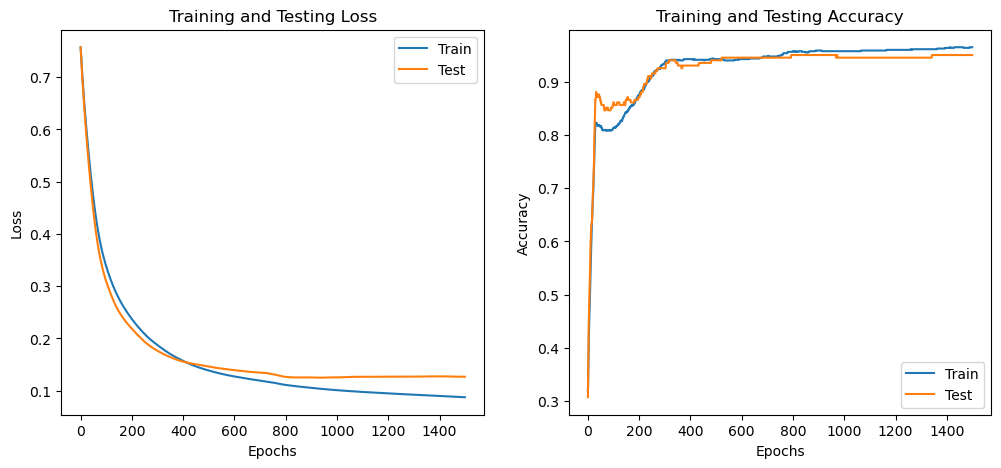

In [327]:
# Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train')
plt.plot(test_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

Con este nuevo modelo observamos como obtenemos una precisiond del 95% al decir si un support es Tier S o no, pero teniendo en cuenta el uso de la variable score, la cual muy probablemente ya se use para clasificar a los campeones, me parece hacer un poco de trampas. Así que a continuación para mi modelo final lo que haré será deshacerme de esa variable, junto con las de Clase, que aunque segun el test de chi cuadrado influya, no creo que sea buena para el modelo ya que no es la clase en si lo que influye, sino lo que sea que esta fuerte en ese parche, por lo que al no ser algo general solo meteria ruido.

Despues, unificaré el Tier S y el Tier God en uno y haré algo parecido a lo anterior para tratar de determina si un Support pertenece o no a este grupo. Una vez entrenado el modelo será cuando haga la magia para tratar de encontrar los limites que determinan si un support es Tier S.

In [186]:
sup_dat.sample()

,Name,Tier,Score,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA,Class_Assassin,Class_Fighter,Class_Mage,Class_Marksman,Class_Support,Class_Tank,IsTierS
4117,Gragas,1,27.53,-3.18,48.02,11.51,0.42,0.54,2.21,0,1,0,0,0,0,0


In [187]:
sup_dat_limits = sup_dat.drop(['Score', 'Class_Assassin', 'Class_Fighter', 'Class_Mage', 'Class_Marksman', 'Class_Support', 'Class_Tank', 'IsTierS'], axis = 1)
sup_dat_limits['IsTierSorGod'] = ((sup_dat_limits['Tier'] == 5) | (sup_dat_limits['Tier'] == 6)).astype(int)
sup_dat_limits = sup_dat_limits.drop(['Tier'], axis=1)
sup_dat_limits.sample()

,Name,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA,IsTierSorGod
946,Amumu,-3.31,52.0,13.25,0.32,1.43,2.04,0


Epoch [200/1000], Train Loss: 0.0772, Test Loss: 0.0961, Train Accuracy: 0.9714, Test Accuracy: 0.9554
Epoch [400/1000], Train Loss: 0.0604, Test Loss: 0.0689, Train Accuracy: 0.9751, Test Accuracy: 0.9752
Epoch [600/1000], Train Loss: 0.0537, Test Loss: 0.0621, Train Accuracy: 0.9764, Test Accuracy: 0.9752
Epoch [800/1000], Train Loss: 0.0494, Test Loss: 0.0646, Train Accuracy: 0.9826, Test Accuracy: 0.9703
Epoch [1000/1000], Train Loss: 0.0466, Test Loss: 0.0710, Train Accuracy: 0.9838, Test Accuracy: 0.9703


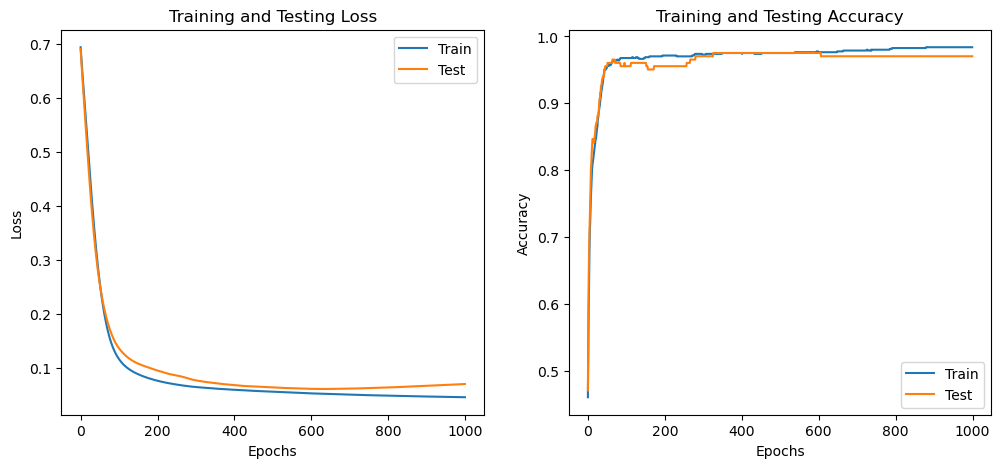

In [188]:
X = sup_dat_limits.drop(['IsTierSorGod', 'Name'], axis = 1)
y = sup_dat_limits['IsTierSorGod']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.to_numpy(), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

########################################################################################################

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    
########################################################################################################
    
input_size = X.shape[1]
hidden_size = 15
output_size = 1
model = MLP(input_size, hidden_size, output_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 1000
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

########################################################################################################
   
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1))

    # Punto clave para el aprendizaje
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluaciones, equivalente a model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train.unsqueeze(1))
        train_predicted = (train_outputs >= 0.5).squeeze().float()
        train_acc = (train_predicted == y_train).sum().item() / y_train.size(0)
        train_accuracy.append(train_acc)
        train_losses.append(train_loss.item())

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.unsqueeze(1))
        test_predicted = (test_outputs >= 0.5).squeeze().float()
        test_acc = (test_predicted == y_test).sum().item() / y_test.size(0)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss.item())


    # Visualización cada 10 epochs
    if (epoch+1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
        
########################################################################################################
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train')
plt.plot(test_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

Como vemos es el modelo del que he obtenido el mejor resultado, y eso nos va de perlas para obtener más precisión en el momento de encontrar los limites. Para hacerlo, primero haré un ejemplo rapido del modus operandi, donde pillaré los datos de un parche de morgana cuando era Tier S, e iré reduciendo de forma iterativa todos sus parametros por un 0,01% hasta que deje de clasificarse como Tier S.

In [304]:
Morgana = sup_dat_limits[(sup_dat_limits['IsTierSorGod'] == 1) & (sup_dat_limits['Name'] == 'Morgana')].sample()
Morgana = Morgana.drop(['IsTierSorGod', 'Name'], axis=1)
Morgana

,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
578,-0.08,50.23,88.21,7.65,25.34,2.47


In [305]:
nuevos_predicted = 1
count = 0

while (nuevos_predicted == 1):
    Morgana = Morgana - Morgana * 0.0001
    count = count + 1
    nuevos_datos_scaled = scaler.transform(Morgana) 
    nuevos_datos_tensor = torch.tensor(nuevos_datos_scaled, dtype=torch.float32)

    model.eval()  # Asegurar que el modelo está en modo de evaluación
    with torch.no_grad():
        nuevos_outputs = model(nuevos_datos_tensor)
        nuevos_predicted = (nuevos_outputs >= 0.5).squeeze().float()

print(count)
print(Morgana)

450
       Trend    WinPerc   RolePerc  PickPerc    BanPerc       KDA
578 -0.07648  48.019645  84.328348  7.313364  24.224922  2.361308


Estos serian los limites de morgana, sin embargo esto no puede generalizarse ya que habrán veces que una variable tire mas que otra, o tenga un valor muy exagerado. Por ello lo que haré será quedarme con todos los supports de Tier S o God, y aplicaré esta misma tecnica a todos hasta que deje de clasificarlos como tal. Despues añadire los datos modificados a un dataframe y las medias de los valores de este dataframe serán los valores límites medios a partir de los cuales un campeón es Tier S.

In [306]:
TierS = sup_dat_limits[(sup_dat_limits['IsTierSorGod'] == 1)]
TierS = TierS.drop(['IsTierSorGod', 'Name'], axis=1)
TierS.describe()

,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.684719,50.478218,91.724620,8.947690,11.879307,2.780363
std,7.516981,1.478160,10.652281,2.309068,9.077747,0.499099
min,-27.450000,46.370000,49.920000,4.170000,0.310000,2.110000
25%,-2.395000,49.410000,89.120000,7.260000,3.905000,2.440000
50%,0.120000,50.330000,96.270000,8.750000,9.220000,2.650000
75%,3.410000,51.595000,98.405000,10.430000,18.315000,3.050000
max,38.710000,54.370000,99.760000,21.940000,37.430000,4.400000


In [311]:
nuevos_predicted = 1
count = 0

data_testing_limits = pd.DataFrame()

for i in range(0,303):
    nuevos_predicted = 1
    row = TierS.iloc[i]
    while (nuevos_predicted == 1):
        row = row - row * 0.001
        count = count + 1
        nuevos_datos_scaled = scaler.transform([row.values]) 
        nuevos_datos_tensor = torch.tensor(nuevos_datos_scaled, dtype=torch.float32)

        model.eval()  # Asegurar que el modelo está en modo de evaluación
        with torch.no_grad():
            nuevos_outputs = model(nuevos_datos_tensor)
            nuevos_predicted = (nuevos_outputs >= 0.5).squeeze().float()
    data_testing_limits = data_testing_limits.append(pd.DataFrame([row]), ignore_index=True)

data_testing_limits.sample()

,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
234,3.773727,50.793387,69.38757,6.753501,9.772483,2.068199


In [312]:
data_testing_limits.describe()

,Trend,WinPerc,RolePerc,PickPerc,BanPerc,KDA
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.578243,47.451536,86.168509,8.350112,11.016239,2.600319
std,6.940452,2.213746,10.172937,1.900069,8.176349,0.381086
min,-25.593314,41.007340,49.373617,4.157503,0.309071,2.045613
25%,-2.138477,46.602008,83.618273,6.895551,3.686533,2.328700
50%,0.115408,47.865766,88.979212,8.332310,8.742225,2.506556
75%,3.124812,48.676173,92.818812,9.612192,16.902622,2.766465
max,33.016862,52.937010,99.180720,18.526959,32.930803,3.672426


Aqui observamos toda una seria de puntos interesantes en los que fijarnos, primeramente podemos ver los valores medios para cada una de las variables que nos ayudan a determinar el limite entre el Tier S y el A. Estos son los valores medios para los limites, pero tambien apreciamos otros valores como los minimos donde vemos cual es el valor minimo de cada variable a partir del cual se ha llegado a clasificar como Tier S. Esto no seria posible sin un buen modelo clasificador, pero tal y como hemos visto anteriormente, el modelo final tiene una precisión del 97% lo que lo convierte en un modelo de confianza por lo que estos valores podriamos concluir que son representativos.

### Conclusiones

En la realizacion de este notebook, primero hemos visto una primera limpieza de los datos donde he tenido que transformar algún dato y deshacerme de Nas entre otras cosas, después de ello hemos observado las distribuciones de las variables realizado varios tests como el Anova o el de correlaciones para decidir si usar ciertas variables o no y finalmente me he puesto con la creacion 3 modelos distintos de los cuales he usado el último para determinar los limites que convierten a un support en Tier S.

Como el problema no se nos presentaba con un gran numero de variables, ni un gran número de clases donde clasificar y no teniamos una cantidad exagerada de muestras. No ha hecho falta ni acercarme al limite establecido de 10000 parametros, llegando a duras penas a los 1000 parametros para conseguir una clasificacion mas que decente. En cuanto a la creacion de los modelos en sí no ha habido secreto, he usado una unica hidden layer en la que he ido variando el número de neruonas dependiendo del modelo buscando la configuración que me diera más precisión, cosa que también he hecho en el momento de elegir el número de epochs y el learning rate del modelo, y en todos los casos he usado la entropia como criterio para mis modelos.

Como he mencionado en la celda anterior, los resultados obtenidos gracias a la precision del modelo, son altamente representativos y el hecho de haber podido contar con más de 300 muestras de supports de Tier S ha hecho que los valores medios sean más fiables. Eso se debe a que si tomaramos un número muy reducido de muestras, podriamos llegar a tener un sesgo donde debido a valores extremos de alguna de las variables, engañaramos al modelo y encontraramos limites para las otras variables que no fueran los reales, sin embargo con más de 300 muestras estos casos se compensarán con otros y por ello es con el valor de la media de cada variable con el que me quedo para determinar el límite que decide si un campeón es Tier S o no.